# Group Analysis

ToDo
----
- Step across frequencies, and make the 3D plot of performance
- Features: analytic amplitudes of frequency bands

Notes
-------
- Best performance (non-time resolved): LinearSVC with 'mean' feature (with downsampling)
    - Performance: ~30% improvement with alignment (where un-aligned is at chance). 
- SideNote: PyMVPA z-scoring within common space seems to boost performance, when performance is otherwise low

In [1]:
#%matplotlib inline

import os
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from mne import read_epochs
from mne import set_log_level

from hypertools.tools.align import align

# Custom code
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
from hypeeg.settings import *
from hypeeg.analysis import *
from hypeeg.utils import *
from hypeeg.plts import *

In [2]:
# Set MNE log level, to shut up print outs
set_log_level('ERROR')

## Settings

In [3]:
# Check the defined settings
print('Within Feat   \t\t:', DEFAULT_AVG)
print('Number of CVs \t\t:', K_FOLD)
print('# Epochs      \t\t:', N_EPOCHS)
print('Alignment     \t\t:', ALIGN)

Within Feat   		: mean
Number of CVs 		: 10
# Epochs      		: 40
Alignment     		: hyper


## Data Organization / Loading

In [4]:
# Set data location for processed files
dat_path = '/Users/tom/Desktop/HyperEEG_Project/Data/proc/'

In [5]:
# Get list of available files
#  Note: this currently excludes first subject, because they are weird.
dat_files = [file for file in os.listdir(dat_path)[1:] if 'epo.fif' in file]

In [6]:
# Load all data
all_subjs = [read_epochs(os.path.join(dat_path, f_name),
                         preload=True, verbose=None) for f_name in dat_files]

# Grab a time definition
times = np.arange(-1, 1, 1/100)

In [7]:
# Organize subject data into data and label matrices
all_data, all_labels = [], []

for subj in all_subjs:
    
    # Enforce a minimum number of trials - skip subj if not met
    if len(subj) < N_EPOCHS:
        print('Skipping Subj')
        continue
        
    t_data, t_labels = extract_data(subj, l_freq=None, h_freq=None, resample=True)
    all_data.append(t_data)
    all_labels.append(t_labels)

Skipping Subj
Skipping Subj
Skipping Subj


In [8]:
# Check how many subjects there are
n_subjs = len(all_data)
print('Running ', n_subjs, 'subjects.')

Running  13 subjects.


In [9]:
# Sanity check: z-score before everythingt
#all_data = [make_3d(make_2d(dat)) for dat in all_data]

## Within Subject Classification (un-aligned)


In [10]:
# Run within subject classification - non time resolved
within_scores = within_subj_classification(all_data, all_labels)

In [11]:
# Get average results - within and across subjects
within_subj_avgs = np.mean(within_scores, 1)
within_glob_avg = np.mean(within_subj_avgs)

In [12]:
# Check outcome - average across all subjects
print_avg('CV Within-Subj Prediction', within_glob_avg)

CV Within-Subj Prediction: 50.00%


In [13]:
# Check performance on each subject
print_avgs('Per Subj Within Predictions', within_subj_avgs)

Per Subj Within Predictions:
	0 	 0.50
	1 	 0.50
	2 	 0.42
	3 	 0.50
	4 	 0.50
	5 	 0.50
	6 	 0.50
	7 	 0.50
	8 	 0.60
	9 	 0.47
	10 	 0.50
	11 	 0.53
	12 	 0.47


In [14]:
# Within subject classification - time resolved
ts_within_scores = time_within_subj_classification(all_data, all_labels)

In [15]:
# Collapse across k-folds
ts_within_scores = np.mean(ts_within_scores, 2)

## Between Subject Classification (un-aligned)

In [16]:
# Run prediction between subjects - on unaligned data
btwn_scores = btwn_subj_classication(all_data, all_labels)

In [17]:
# Get average results
avg_btwn_scores = np.mean(btwn_scores)

In [18]:
# Check outcome - average across all subjects
print_avg('Btwn-Subj Prediction', avg_btwn_scores)

Btwn-Subj Prediction: 51.54%


In [19]:
# Check performance on each subject (non-time resolved)
print_avgs('Btwn Subject Classification', btwn_scores)

Btwn Subject Classification:
	0 	 0.53
	1 	 0.50
	2 	 0.50
	3 	 0.50
	4 	 0.50
	5 	 0.53
	6 	 0.50
	7 	 0.50
	8 	 0.65
	9 	 0.50
	10 	 0.50
	11 	 0.50
	12 	 0.50


In [20]:
# Check time
ts_btwn_scores = time_btwn_subj_classification(all_data, all_labels)

## Alignment (Hypertools)


In [21]:
# Data organization - extract matrices, and flatten to continuous data
all_data_2d = [make_2d(dat) for dat in all_data]

In [22]:
# Do alignment
#  Note: this also switches orientation (takes the transpose) to match hypertools
#    This is because align assumes [n_samples x n_channels]
aligned_data = align([dat.T for dat in all_data_2d], align=ALIGN)
aligned_data = [dat.T for dat in aligned_data]
aligned_data = [make_3d(dat) for dat in aligned_data]

## Between Subject Classification (aligned)

In [23]:
# Check within subject prediction of aligned data
within_al1_scores = within_subj_classification(aligned_data, all_labels)
print_avg('Within Aligned', np.mean(within_al1_scores))
print_avgs('\nPer subj Within-Aligned', np.mean(within_al1_scores, 1))

Within Aligned: 52.50%

Per subj Within-Aligned:
	0 	 0.62
	1 	 0.55
	2 	 0.30
	3 	 0.57
	4 	 0.53
	5 	 0.53
	6 	 0.42
	7 	 0.53
	8 	 0.57
	9 	 0.55
	10 	 0.57
	11 	 0.68
	12 	 0.40


In [24]:
# Run prediction between subjects - on aligned data
btwn_al_scores = btwn_subj_classication(aligned_data, all_labels)

In [25]:
# Get average results
avg_btwn_al_scores = np.mean(btwn_al_scores)

In [26]:
# Check outcome - average across all subjects
print_avg('Btwn-Subj Prediction', avg_btwn_al_scores)

Btwn-Subj Prediction: 79.23%


In [27]:
# Check performance on each subject
print_avgs('Btwn Subject Classification', btwn_al_scores)

Btwn Subject Classification:
	0 	 0.88
	1 	 0.80
	2 	 0.65
	3 	 0.90
	4 	 0.82
	5 	 0.85
	6 	 0.93
	7 	 0.82
	8 	 0.70
	9 	 0.57
	10 	 0.90
	11 	 0.72
	12 	 0.75


In [28]:
# Run prediction between subjects - on aligned data, across time points
ts_btwn_al_scores = time_btwn_subj_classification(aligned_data, all_labels)

In [29]:
# Calculate average across time points
avg_time_class_btwn_al = np.mean(ts_btwn_al_scores, 0)

In [30]:
# Set up data for plotting
#results = [avg_time_class_within, avg_time_class_btwn, avg_time_class_btwn_al]
results = [ts_within_scores, ts_btwn_scores, ts_btwn_al_scores]
labels = ['Within', 'Between', 'Btwn-Al']

In [31]:
# Plot the results across time, between classification approaches
plot_results(times, results, labels)

In [32]:
# Feature selection:
# - Analytic amplitude as opposed to raw signal

In [ ]:
raise ValueError('Stop Here')

## Trajectory Plots

Average of the aligned data, within event type

In [171]:
%matplotlib notebook

import hypertools as hyp

In [172]:
al_1 = np.concatenate([dat[0:20, :, :] for dat in aligned_data], 0)
al_2 = np.concatenate([dat[20:, :, :] for dat in aligned_data], 0)

avg_al_1 = np.mean(al_1, 0)
avg_al_2 = np.mean(al_2, 0)

In [173]:
np.save('avg_al_1', avg_al_1)
np.save('avg_al_2', avg_al_2)

In [174]:
una_1 = np.concatenate([zscore(dat[0:20, :, :], 0) for dat in all_data], 0)
una_2 = np.concatenate([zscore(dat[20:, :, :], 0) for dat in all_data], 0)

avg_una_1 = np.mean(una_1, 0)
avg_una_2 = np.mean(una_2, 0)

In [175]:
np.save('avg_una_1', avg_una_1)
np.save('avg_una_2', avg_una_2)

In [176]:
# Load data - aligned data
avg_al_1 = np.load('avg_al_1.npy')
avg_al_2 = np.load('avg_al_2.npy')

<IPython.core.display.Javascript object>


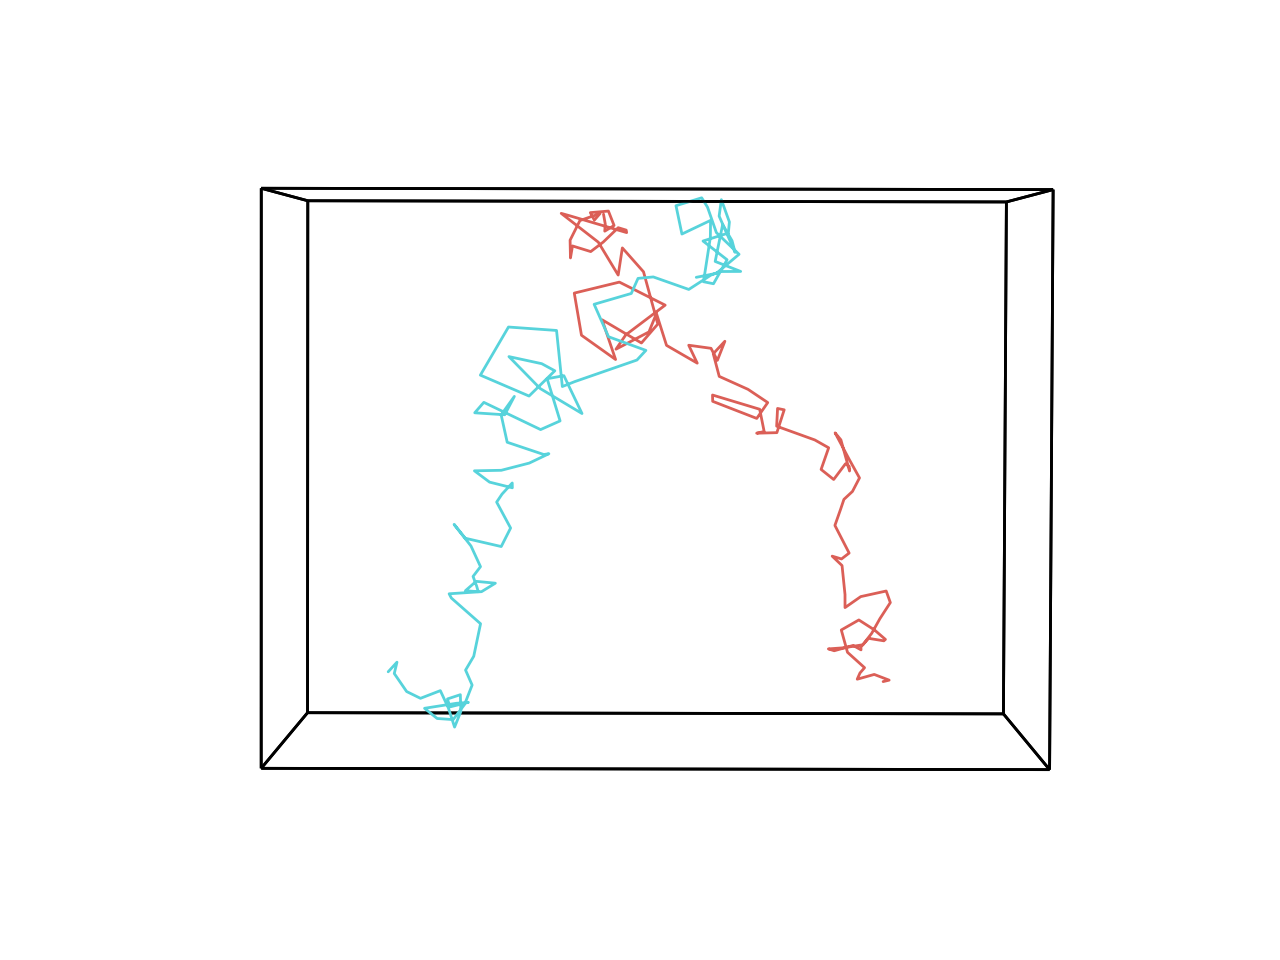

In [177]:
# Aligned data
hyp.plot([avg_al_1.T, avg_al_2.T], animate=True)#, chemtrails=True)

In [180]:
# Load data - unaligned data
avg_una_1 = np.load('avg_una_1.npy')
avg_una_2 = np.load('avg_una_2.npy')

<IPython.core.display.Javascript object>


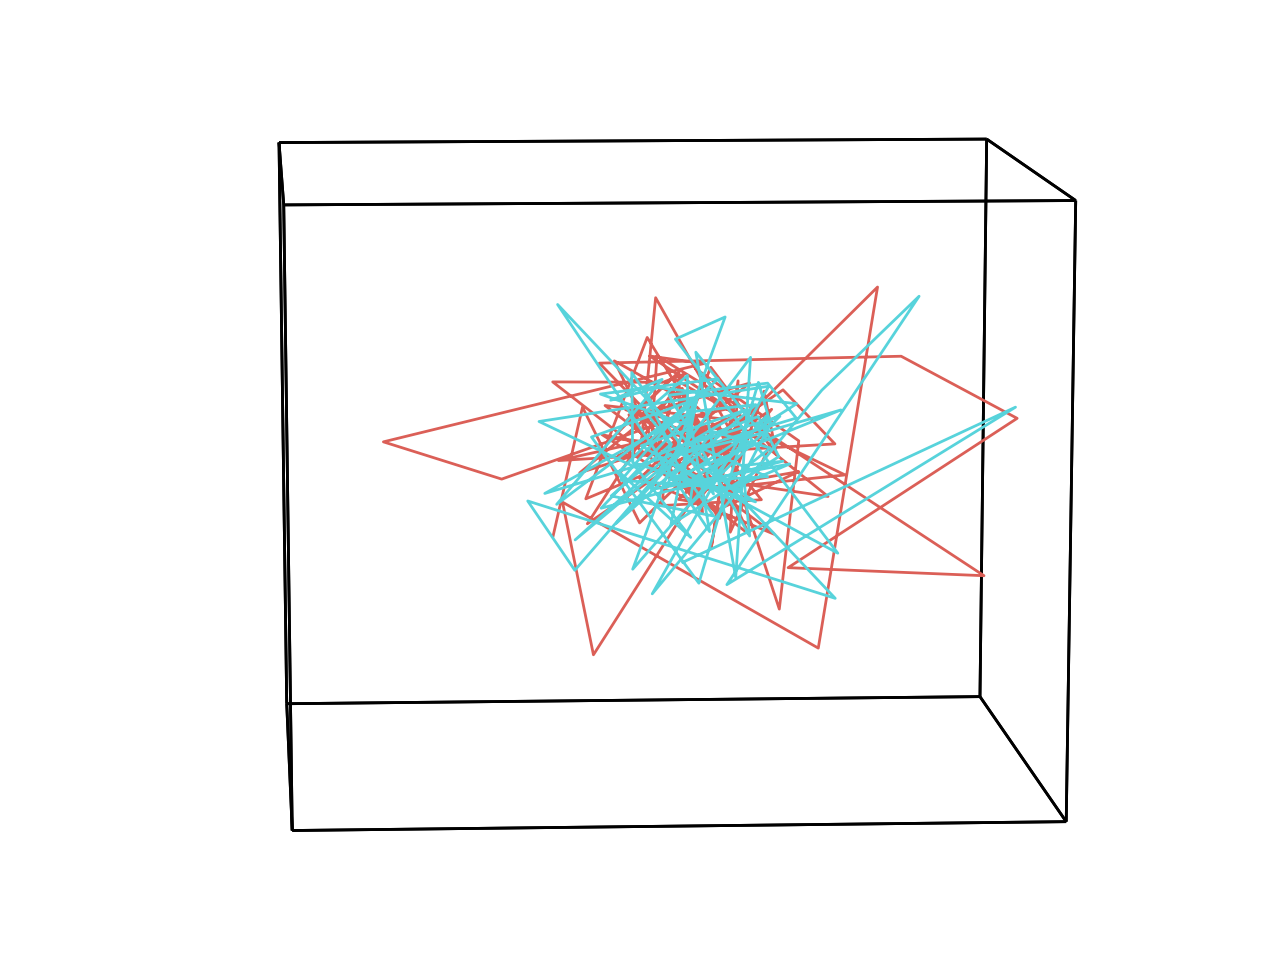

In [181]:
# Unaligned data
hyp.plot([avg_al_1.T, avg_al_2.T], animate=True)#, chemtrails=True)

<IPython.core.display.Javascript object>


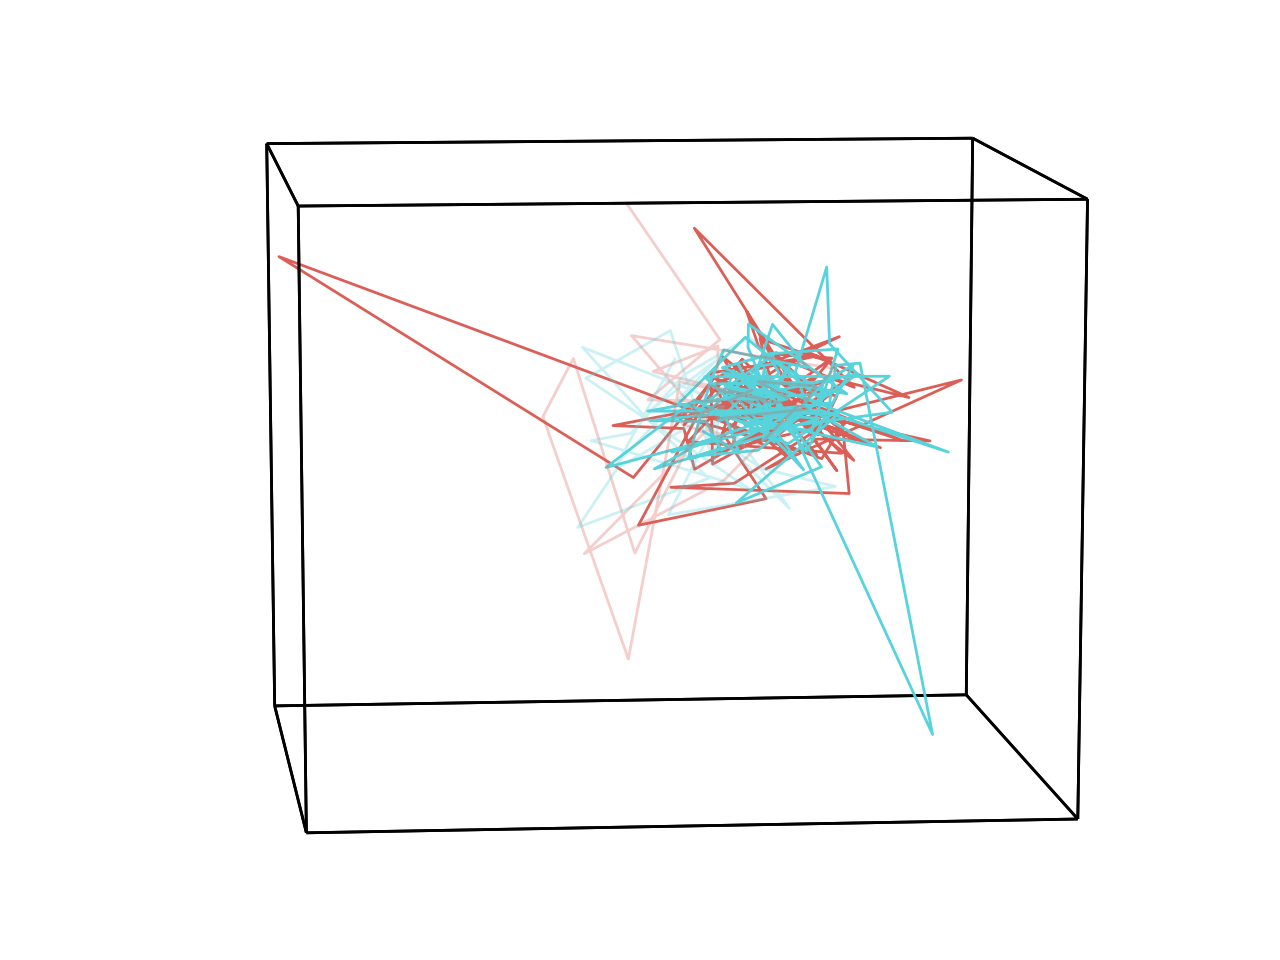

In [ ]:
subj_ind = 2

In [ ]:
#
hyp.plot([np.mean(aligned_data[subj_ind][0:20], 0), np.mean(aligned_data[subj_ind][21:], 0)],
         animate=True, chemtrails=True)

# Single Trial:
#hyp.plot([aligned_data[subj_ind][0, :, :], aligned_data[subj_ind][-1, :, :]], animate=True, title='Aligned')

In [ ]:
hyp.plot([np.mean(all_data[subj_ind][0:20], 0), np.mean(all_data[subj_ind][21:], 0)],
         animate=True)#, chemtrails=True)

# Single Trial:
#hyp.plot([all_data[subj_ind][:, 0:200], all_data[subj_ind][:, -200:]], animate=True, title='Unaligned')

#### CHECKS
Compare hyperaligned to unaligned data

In [ ]:
# Note: these checks are for test cases which use a group of the same data copied over
#print(np.all(all_data[0] == all_data[1]))
#print(np.all(aligned_data[0] == aligned_data[1]))
#print(np.all(aligned_data[0] == all_data[0]))

## Check random rotations

In [ ]:
# Random rotation matrix
#rot = np.random.random(size=n_chs*n_chs).reshape([n_chs, n_chs])

In [ ]:
# Rotation by random matrix
#twod_dat = deepcopy(all_data)
#twod_dat = [np.dot(rot, dat) for dat in twod_dat]
#twod_dat_3d = [make_3d(dat) for dat in twod_dat]

In [ ]:
# Check within subject prediction of random data
#within_rand_scores = within_subj_classification(twod_dat_3d, all_labels)
#print_avg('Within Rand', np.mean(within_rand_scores))

In [ ]:
# Between subject classification
#rand_btwn_scores = btwn_subj_classication(twod_dat_3d, all_labels)

In [ ]:
# Check outcome - average across all subjects
#avg_rand_btwn = np.mean(rand_btwn_scores)
#print_avg('Random Btwn-Subj Prediction', avg_rand_btwn)

## PyMVPA

Apply hyperalignment implementation from the PyMVPA package.

Note: this requires being in a Py2 environment with PyMVPA available.

In [ ]:
from mvpa2.datasets.base import Dataset
from mvpa2.algorithms.hyperalignment import Hyperalignment

In [ ]:
# Re-organize data into PyMVPA datasets objects
datasets = [Dataset(dat.T) for dat in all_data]

In [ ]:
# Run hyperalignment, and get the transformation matrices
hyper_aligner = Hyperalignment(level2_niter=0, zscore_all=False, zscore_common=False)
hyper_aligner.train(datasets)
mappers = hyper_aligner(datasets)

In [ ]:
# Apply the transformations to each dataset, and re-organize data
#   This applies the projection to the 2D data, transpose, and split back into epochs
aligned_datasets = []
for dataset, mapper in zip(datasets, mappers):
    aligned_datasets.append(make_3d(mapper.forward(dataset).samples.T))

In [ ]:
# Check within subject prediction of aligned data
within_al2_scores = within_subj_classification(aligned_datasets, all_labels)
print_avg('Within Al2', np.mean(within_al2_scores))

In [ ]:
# Between subject classification after PyMVPA hyperalignment
btwn_al2_scores = btwn_subj_classication(aligned_datasets, all_labels)

In [ ]:
# Check average performance
avg_btwn_al2 = np.mean(btwn_al2_scores)
print_avg('Aligned-2 Btwn Scores', avg_btwn_al2)

In [ ]:
# 
print_avgs('Between Subj Aligned Data', btwn_al2_scores)

In [ ]:
# Check if the rotation matrices are the same
#np.all(mappers[0].proj == mappers[1].proj)

#### Compare between the two hyperalignment implementations

In [ ]:
# Check the magnitude of differences between aligned data
#diff = aligned_datasets[0] - aligned_data[0]

In [ ]:
#print('Avg Magnitude Diff', np.mean(np.abs(diff)))
#print('Avg Magnitude Data', np.mean(np.abs(aligned_datasets[0])))

In [ ]:
# Check number of overlapping points
#from __future__ import division
#np.sum(np.isclose(aligned_datasets[0], aligned_data[0])) / aligned_data[0].size

## Victory Party.

Soon...